In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Bitcoin Analysis") \
    .master("local[*]") \
    .getOrCreate()

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window as W
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
data_df = spark.read.parquet('../data/bitcoin.pq', header=True, inferSchema=True)
data_df.show(3)

+--------------------+----+---+------+------------------+-----+------+---------+--------+---------------+
|             address|year|day|length|            weight|count|looped|neighbors|  income|          label|
+--------------------+----+---+------+------------------+-----+------+---------+--------+---------------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.0083333333333333|    1|     0|        2|1.0005E8|princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|     2.44140625E-4|    1|     0|        1|   1.0E8| princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|               1.0|    1|     0|        2|   2.0E8|princetonCerber|
+--------------------+----+---+------+------------------+-----+------+---------+--------+---------------+
only showing top 3 rows



In [6]:
#Pre-processing
#Handling null values
print('Before: ', data_df.count())
data_df = data_df.dropna()
print('After: ', data_df.count())

Before:  2916697
After:  2916697


In [ ]:
#Handling null values
print('Before: ', data_df.count())
data_df = data_df.dropDuplicates()
print('After: ', data_df.count())

Before:  2916697
After:  2916697


In [7]:
#add day of the week and month
new_df = data_df.withColumn('day_of_week', F.dayofweek(F.to_date(F.concat_ws("-", F.col("year"), F.col("day")), "yyyy-D")))
new_df = new_df.withColumn('month', F.month(F.to_date(F.concat_ws("-", F.col("year"), F.col("day")), "yyyy-D")))

In [8]:
#is holiday
#if the day is within 1 week leading upto the holiday or after the holiday return True
public_holidays = [
    1, #New Year’s Day, January 1
    15, #Birthday of Martin Luther King, Jr, 15 January
    53, #Washington's birthday February 22
    151, #Memorial day, May 31
    185, #Independence day, July 4
    121, #Labor day, May 1
    285, #Columbus day, October 12
    315, #Veteran's day, November 11
    330, #Thanksgiving day, November 26
    360, #Christmas day, December 25
]
new_df = new_df.withColumn('isHoliday', F.when(F.col('day').isin(public_holidays), 1).otherwise(0))

In [9]:
#tansform label into binary col
new_df = new_df.withColumn('label', F.when(F.col('label')!='white', 'black').otherwise('white'))

In [ ]:
new_df.show(3)

+--------------------+----+---+------+-----------------+-----+------+---------+------+-----+-----------+-----+---------+
|             address|year|day|length|           weight|count|looped|neighbors|income|label|day_of_week|month|isHoliday|
+--------------------+----+---+------+-----------------+-----+------+---------+------+-----+-----------+-----+---------+
|127wN6kNKCdVPvBRH...|2015|209|   144|0.195316232326441| 2692|     0|        1|1.79E8|black|          3|    7|        0|
|128meNE6VGJqDX4H6...|2014| 79|   144| 3.19191919192199| 1691|     3|        8|3.63E9|black|          5|    3|        0|
|12h6JSCy5gTymZHo4...|2016|243|     6|              0.5|    1|     0|        2| 2.0E8|black|          3|    8|        0|
+--------------------+----+---+------+-----------------+-----+------+---------+------+-----+-----------+-----+---------+
only showing top 3 rows



In [ ]:
sample_fraction = 0.8  # Adjust the fraction as needed
pd_df = new_df.sample(fraction=sample_fraction, withReplacement=False).toPandas()

In [11]:
#basic EDA
pd_df = new_df.toPandas()

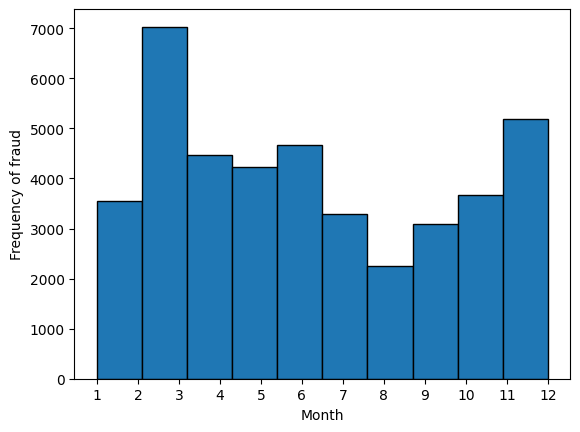

In [13]:
#month-wise fraud frequency
black_df = pd_df[pd_df['label']=='black']
plt.hist(black_df['month'], edgecolor='black')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel('Month')
plt.ylabel('Frequency of fraud')
plt.show()

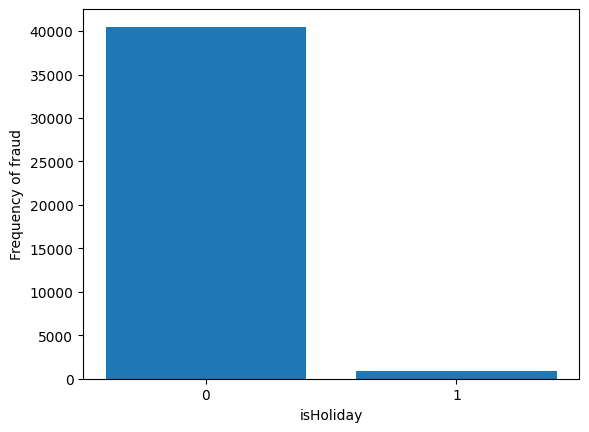

In [14]:
plt.bar ([0,1], [len(black_df[black_df['isHoliday']==x]) for x in [0,1]])
plt.xticks([0,1])
plt.xlabel('isHoliday')
plt.ylabel('Frequency of fraud')
plt.show()

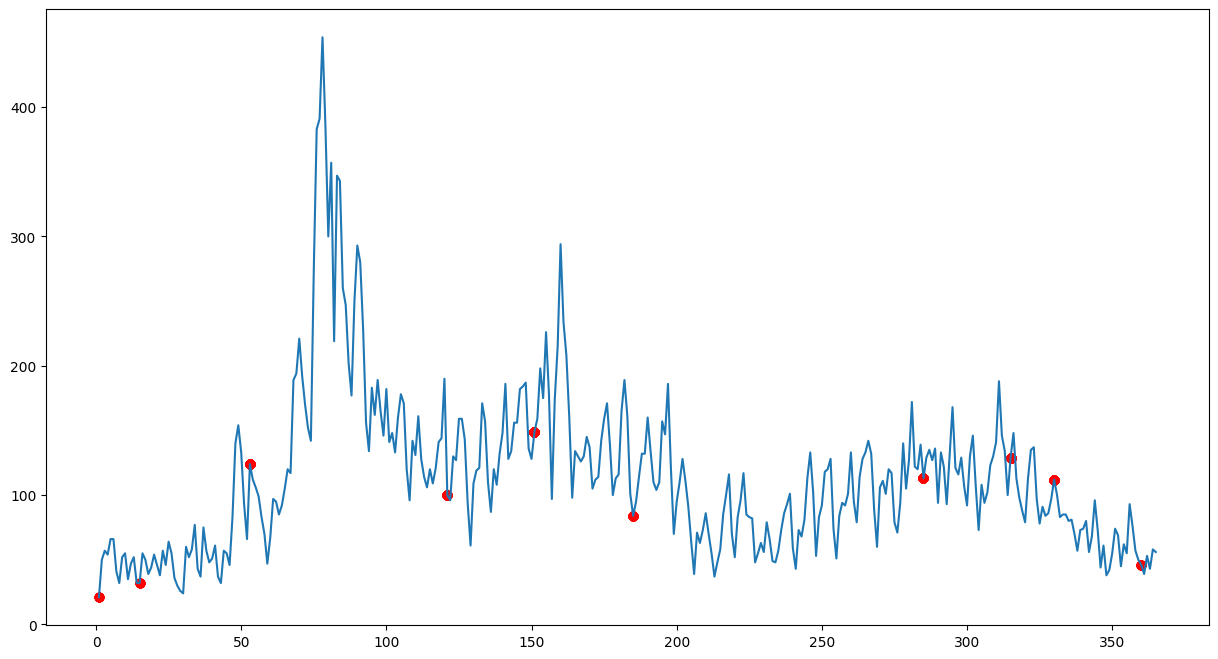

In [15]:
#frequency of fraud over a year
plt.figure(figsize=(15,8))
x = list(range(1,366))
y = [len(black_df[black_df['day']==i]) for i in x]
plt.plot(x,y)

x_2=list(black_df.query("isHoliday==1")['day'])
y_2 = [len(black_df[black_df['day']==i]) for i in x_2]
plt.scatter(x_2, y_2, c='r')
plt.show()

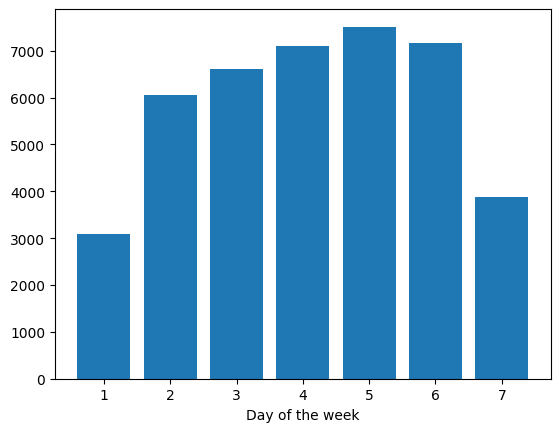

In [ ]:
#day-of-the-week analysis
x = list(range(1,8))
y = [len(black_df[black_df['day_of_week']==i]) for i in x]
plt.bar(x,y)
plt.xlabel('Day of the week')
plt.show()

<BarContainer object of 8 artists>

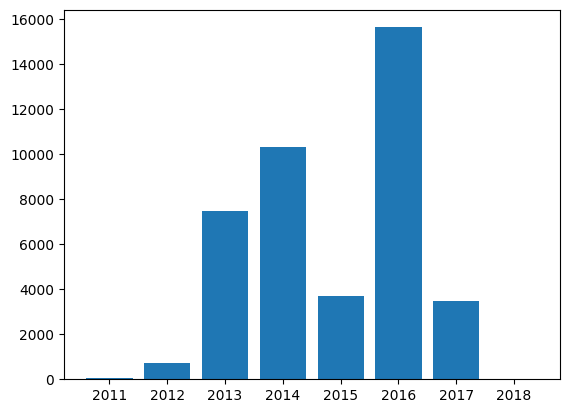

In [29]:
x=black_df['year'].unique()
y=[len(black_df[black_df['year']==i]) for i in x]
plt.bar(x,y)